# 2.0 Napari

## Simple setup

To use the `src` module inside of the notebooks:

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import ast
import napari
import src # Load custom functions.
import shapely
import shapely.ops

import pandas as pd
import shapely.geometry as geometry

from dask_image.imread import imread

## Initalize an empty Napari Viewer

In [3]:
%gui qt5
viewer = napari.Viewer()

## Display channels

In [4]:
display_specification = dict(
    # DIC = dict(colormap="gray", visible=True, opacity=0.2),
    DsRed = dict(colormap="red"),
    GFP = dict(colormap="green")
) 

In [5]:
channels_stacks = {
    path.stem: imread(path.joinpath("*.tif"))
    for path in src.data_dir("sample", "tif", "xy02").glob("*")
    if path.is_dir() and path.stem in display_specification
}
channels_stacks

{'DsRed': dask.array<_map_read_frame, shape=(25, 512, 640), dtype=uint16, chunksize=(1, 512, 640), chunktype=numpy.ndarray>,
 'GFP': dask.array<_map_read_frame, shape=(25, 512, 640), dtype=uint16, chunksize=(1, 512, 640), chunktype=numpy.ndarray>}

In [6]:
%gui qt5

for name, stack in channels_stacks.items():
     viewer.add_image(
         stack, name=name,
         blending="additive",
         contrast_limits=[0, 2000],
         multiscale=False,
         **display_specification[name]
    )

## Read and transform roi's pickle files.

In [7]:
roi_files = sorted(
    src.data_dir("sample", "data_cells_tracked", "xy02", "normData").glob("*.pkl")
)

tracked_cells_df = (
    # Read pickle files into a single data frame.
    pd.DataFrame(
        dict(
            list_str_cells = [pd.read_pickle(file) for file in roi_files]
        )
    )
    # Each observation is a list of strings.
    # Convertet to long format.
    .explode(column="list_str_cells")
    # Each string is a set of variables delimited by tab.
    .list_str_cells
    .str.rstrip("\t")
    .str.split(r"\t+", expand=True) # One column per variable.
    .reset_index()
    # Indicate actual column values.
    .rename(columns = {
        "index": "frame",
        0: "id",
        1: "color",
        2: "roi_id",
        3: "track_id",
        4: "roi_polygon",
        5: "center",
        6: "axis",
        7: "GFP",
        8: "DsRed",
        9: "dead",
        10: "previous_frame",
        11: "next_frame",
        12: "mother_id"
    })
    # Transfrom shape-strings columns into geometries.
    .assign(
        roi_polygon=lambda df: df.roi_polygon.apply(ast.literal_eval).apply(geometry.Polygon),
        center=lambda df: df.center.apply(ast.literal_eval).apply(geometry.Point),
        axis=lambda df: df.axis.apply(ast.literal_eval).apply(geometry.LineString)
    )
    # Swap coordinates since napari and ImageJ has inverted axes.
    .assign(
         roi_polygon=lambda df: df.roi_polygon.apply(
            lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon)
        )
    )
)

tracked_cells_df.head(1)

,frame,id,color,roi_id,track_id,roi_polygon,center,axis,GFP,DsRed,dead,previous_frame,next_frame,mother_id
0,0,20.0,#abcdcd,roi_f20_n0_x234_y409,[],"POLYGON ((410 238, 410 239, 411 239, 411 240, ...",POINT (233.6920667302324 410.6278959176846),LINESTRING (246.9999999999999 430.683093054870...,587.0,98.795,0,[],[],[]


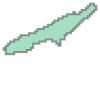

In [8]:
tracked_cells_df.roi_polygon.to_list()[0]